#Deep Learning. Задание №2.
###Вариант 5. Классификация по представлениям из трансформера.
###Ашинов Б.Р. 317 группа.

Необходимо рассмотреть задачу классификации текстов, исследовать различные архитектуры трансформеров и различные способы получить из них векторные представления, обучить классические ML-модели на этих представлениях, сделать выводы о том, какая архитектура и какой способ представления подходит лучше для рассматриваемой задачи, подобрать наиболее удачную классическую модель классификации.\
Для исследования использовался датасет IMDb Review: \
 https://ai.stanford.edu/~amaas/data/sentiment/ \
https://pytorch.org/text/stable/_modules/torchtext/datasets/imdb.html

##Всякие импорты

In [1]:
from google.colab import output

In [2]:
!pip install torchdata
output.clear()

In [3]:
!pip install sentencepiece
output.clear()

In [4]:
!pip install transformers
output.clear()

In [5]:
!pip install catboost
output.clear()

In [6]:
import numpy as np
import torch
from torchvision.datasets import SVHN
import torchvision
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.optim as optim


import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
%matplotlib inline
%config InlineBackend.figure_formats = ['pdf', 'svg']
from tqdm.notebook import tqdm
from functools import partial
import torchtext.data
import math

In [7]:
from transformers import BertTokenizer, BertModel, AlbertTokenizer, AlbertModel, RobertaTokenizer, RobertaModel

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

##Важные функции

Здесь реализованы функции для получения векторных представлений из текстов на основе трансформера. Каждая функция получает на вход соответствующий токенизатор, предобученный трансформер и тексты. Возвращает векторные представления текстов в виде матрицы $l\times d$, $l$ - размер выборки, $d$ - размерность вектора-представления одного текста.

1. В этом способе получения векторов усредняем выходы последнего слоя, получаем вектор длины 768 для каждого текста.

In [10]:
def get_embedds_last_mean(tokenizer, transformer, texts, device, *args, **kwargs):
    x = None
    transformer.eval()
    transfromer = transformer.to(device)
    with torch.no_grad():
        for i in tqdm(range(0, len(texts))):
            tokenized = tokenizer(texts[i], return_tensors="pt", padding='max_length', truncation=True, max_length=512)
            tokenized = tokenized.to(device)
            out = transformer(output_hidden_states=True, **tokenized).last_hidden_state
            out = out.to('cpu')
            out = out.detach().numpy().mean(axis=1)
            if x is None:
                x = out
            else:
                x = np.concatenate([x, out], axis=0)
            tokenized = None
            out = None
    return x

2. Конкатенируем выходы 4 последних скрытых слоев для каждого токена, затем усредняем по тексту и получаем для каждого текста вектор длины 3072 = 4 * 768.

In [11]:
def get_embedds_4last_concat_mean(tokenizer, transformer, texts, device, *args, **kwargs):
    x = None
    transformer.eval()
    transfromer = transformer.to(device)
    with torch.no_grad():
        for i in tqdm(range(0, len(texts))):
            tokenized = tokenizer(texts[i], return_tensors="pt", padding='max_length', truncation=True, max_length=512)
            tokenized = tokenized.to(device)
            hidden = transformer(output_hidden_states=True, **tokenized).hidden_states
            
            embeddings = torch.stack(hidden, dim=0).to('cpu')
            embeddings = embeddings.detach().numpy().squeeze(axis=1).transpose(1, 0, 2)
            last4_cats = []
            for tok in embeddings:
                last4_cat = np.concatenate((tok[-1], tok[-2], tok[-3], tok[-4]), axis=0)
                last4_cats.append(last4_cat)
            last4_cats_mean = np.array(last4_cats).mean(axis=0)
            last4_cats_mean = last4_cats_mean.reshape(1, last4_cats_mean.size)
            if x is None:
                x = last4_cats_mean
            else:
                x = np.concatenate([x, last4_cats_mean], axis=0)
            tokenized = None
            out = None
    return x

3. Суммируем 4 последних скрытых слоя для каждого токена, затем, как ранее, усредняем по тексту и получаем вектор длины 768.

In [12]:
def get_embedds_4last_sum_mean(tokenizer, transformer, texts, device, *args, **kwargs):
    x = None
    transformer.eval()
    transfromer = transformer.to(device)
    with torch.no_grad():
        for i in tqdm(range(0, len(texts))):
            tokenized = tokenizer(texts[i], return_tensors="pt", padding='max_length', truncation=True, max_length=512)
            tokenized = tokenized.to(device)
            hidden = transformer(output_hidden_states=True, **tokenized).hidden_states
            
            embeddings = torch.stack(hidden, dim=0).to('cpu')
            embeddings = embeddings.detach().numpy().squeeze(axis=1).transpose(1, 0, 2)
            last4_sums = []
            for tok in embeddings:
                last4_sum = np.sum((tok[-4:]), axis=0)
                last4_sums.append(last4_sum)
            last4_sums_mean = np.array(last4_sums).mean(axis=0)
            last4_sums_mean = last4_sums_mean.reshape(1, last4_sums_mean.size)
            if x is None:
                x = last4_sums_mean
            else:
                x = np.concatenate([x, last4_sums_mean], axis=0)
            tokenized = None
            out = None
    return x

##Данные

Датасет - отзывы на фильмы IMDB. Возьмем не полный датасет - 10000 случайных текстов из обучающей выборки и 2000 случайных текстов из тестовой(чтобы быстрее проводить эксперименты).

In [13]:
from torchtext.datasets import IMDB
train_data = IMDB(split='train')
test_data = IMDB(split='test')

train_texts = []
train_labels = []
test_texts = []
test_labels = []

for label, line in train_data:
    train_texts.append(line)
    train_labels.append(label)

for label, line in test_data:
    test_texts.append(line)
    test_labels.append(label)

In [14]:
np.random.seed(seed=777)
train_inds = np.random.choice(len(train_labels), size=10000, replace=False)
test_inds = np.random.choice(len(test_labels), size=2000, replace=False)

train_texts, test_texts = np.array(train_texts)[train_inds], np.array(test_texts)[test_inds]
train_labels, test_labels = np.array(train_labels)[train_inds], np.array(test_labels)[test_inds]

In [15]:
y_train, y_test = np.zeros(len(train_labels), dtype=np.int64), np.zeros(len(test_labels), dtype=np.int64)
y_train[np.array(train_labels) == 'pos'] = 1
y_test[np.array(test_labels) == 'pos'] = 1

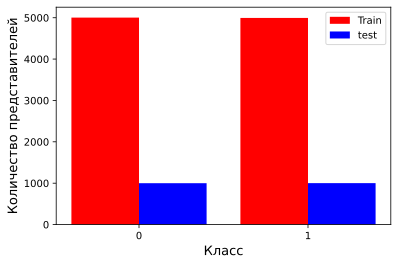

In [16]:
x1 = np.arange(0, 2) - 0.2
x2 = np.arange(0, 2) + 0.2
plt.bar(x1, [y_train.sum(), y_train.size - y_train.sum()], color='red', label='Train', width=0.4)
plt.bar(x2, [y_test.sum(), y_test.size - y_test.sum()], color='blue', label='test', width=0.4)
plt.xticks([0, 1])
plt.xlabel("Класс", fontsize=13)
plt.ylabel("Количество представителей", fontsize=13)
plt.legend()
plt.show()

Как видно, классы очень сбалансированы - представителей примерно поровну. Показатели качества, которые будем рассматривать - Accuracy и ROC-AUC.

##Эксперименты

Для начала выберем оптимальную архитектуру - рассмотрим векторные представления, которые получаются усреднением выходов последнего слоя и логистическую регрессию. Обучим лог. регрессию, измерим качество на тестовой выборке.

###Трансформеры

Список рассматриваемых трансформеров: \


*   BERT (base-версия) \
*   RoBERTa (base-версия) \
*   AlBERT (base-v2) \

In [ ]:
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
output.clear()

In [17]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base")
output.clear()

In [ ]:
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
albert_model = AlbertModel.from_pretrained('albert-base-v2')
output.clear()

In [ ]:
train_bert = get_embedds_last_mean(bert_tokenizer, bert_model, train_texts, device)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
test_bert = get_embedds_last_mean(bert_tokenizer, bert_model, test_texts, device)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
train_roberta = get_embedds_last_mean(roberta_tokenizer, roberta_model, train_texts, device)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
test_roberta = get_embedds_last_mean(roberta_tokenizer, roberta_model, test_texts, device)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
train_albert = get_embedds_last_mean(albert_tokenizer, albert_model, train_texts, device)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
test_albert = get_embedds_last_mean(albert_tokenizer, albert_model, test_texts, device)

  0%|          | 0/2000 [00:00<?, ?it/s]

###Выбираем наиболее удачные архитектуры на основе логистической регрессии

In [ ]:
logreg_bert = LogisticRegression(max_iter=10000)
logreg_bert.fit(train_bert, y_train)
pred_bert = logreg_bert.predict(test_bert)
accuracy_bert = accuracy_score(y_test, pred_bert)
roc_auc_bert = roc_auc_score(y_test, logreg_bert.predict_proba(test_bert)[:, 1])
print(accuracy_bert, roc_auc_bert)

0.879 0.9528919528919529


In [ ]:
logreg_roberta = LogisticRegression(max_iter=10000)
logreg_roberta.fit(train_roberta, y_train)
pred_roberta = logreg_roberta.predict(test_roberta)
accuracy_roberta = accuracy_score(y_test, pred_roberta)
roc_auc_roberta = roc_auc_score(y_test, logreg_roberta.predict_proba(test_roberta)[:, 1])
print(accuracy_roberta, roc_auc_roberta)

0.9165 0.9682039682039683


In [ ]:
logreg_albert = LogisticRegression(max_iter=10000)
logreg_albert.fit(train_albert, y_train)
pred_albert = logreg_albert.predict(test_albert)
accuracy_albert = accuracy_score(y_test, pred_albert)
roc_auc_albert = roc_auc_score(y_test, logreg_albert.predict_proba(test_albert)[:, 1])
print(accuracy_albert, roc_auc_albert)

0.892 0.9595919595919596


В таблице представлены результаты. Как видно, наиболее удачной является архитектура RoBERTA. Далее будем рассматривать ее.

|Архитектура|Accuracy|ROC-AUC|
|-----------|--------|-------|
|BERT       |0.889   |0.95   |
|RoBERTa    |0.917   |0.97   |
|AlBERT     |0.892   |0.96   |

###Выбираем наиболее удачное векторное представление: 
Out-mean \
4hidden-pooling \
4hidden-sum

In [ ]:
train_last_mean = get_embedds_last_mean(roberta_tokenizer, roberta_model, train_texts, device)
test_last_mean = get_embedds_last_mean(roberta_tokenizer, roberta_model, test_texts, device)
output.clear()

In [18]:
train_4last_sum = get_embedds_4last_sum_mean(roberta_tokenizer, roberta_model, train_texts, device)
test_4last_sum = get_embedds_4last_sum_mean(roberta_tokenizer, roberta_model, test_texts, device)
output.clear()

In [ ]:
train_4last_cat = get_embedds_4last_concat_mean(roberta_tokenizer, roberta_model, train_texts, device)
test_4last_cat = get_embedds_4last_concat_mean(roberta_tokenizer, roberta_model, test_texts, device)
output.clear()

In [ ]:
logreg_outmean = LogisticRegression(max_iter=10000)
logreg_outmean.fit(train_last_mean, y_train)
accuracy_outmean = accuracy_score(y_test, logreg_outmean.predict(test_last_mean))
roc_auc_outmean = roc_auc_score(y_test, logreg_outmean.predict_proba(test_last_mean)[:, 1])
print(f'Out-mean\n accuracy:{accuracy_outmean}, roc-auc: {roc_auc_outmean}')

logreg_4last_sum = LogisticRegression(max_iter=10000)
logreg_4last_sum.fit(train_4last_sum, y_train)
accuracy_4last_sum = accuracy_score(y_test, logreg_4last_sum.predict(test_4last_sum))
roc_auc_4last_sum = roc_auc_score(y_test, logreg_4last_sum.predict_proba(test_4last_sum)[:, 1])
print(f'4hidden-sum\n accuracy:{accuracy_4last_sum}, roc-auc: {roc_auc_4last_sum}')

logreg_4last_cat = LogisticRegression(max_iter=10000)
logreg_4last_cat.fit(train_4last_cat, y_train)
accuracy_4last_cat = accuracy_score(y_test, logreg_4last_cat.predict(test_4last_cat))
roc_auc_4last_cat = roc_auc_score(y_test, logreg_4last_cat.predict_proba(test_4last_cat)[:, 1])
print(f'4hidden-pooling\n accuracy:{accuracy_4last_cat}, roc-auc: {roc_auc_outmean}')

Out-mean
 accuracy:0.9165, roc-auc: 0.9682039682039683
4hidden-sum
 accuracy:0.9155, roc-auc: 0.972023972023972
4hidden-pooling
 accuracy:0.9225, roc-auc: 0.9682039682039683


|Способ представления|Accuracy|ROC-AUC|
|--------------------|--------|--------|
|Out-mean            |0.917   |0.968   |
|4hidden-sum         |0.916   |0.972   |
|4hidden-pooling     |0.923   |0.968   |

Видим, что способ с конкатенацией и последующим усреднением последних 4 слоев точность дает лучше, но способ с их суммированием с последующим усреднением лучше упорядочивает объекты, так как ROC-AUC выше. Будем далее рассматрировать этот способ, чтобы выбрать какие ML-классификаторы лучше справляются с задачей

###Перебор параметров RandomForest, LightGBM, CatBoost

In [27]:
logreg_params = {
    'C' : [100, 20, 10, 2, 1]
}

ridge_params = {
    'alpha' : [0.01, 0.05, 0.1, 0.5]
}

lgbm_params = {
    'n_estimators' : [200, 300],
    'max_depth' : [5, 7, 10]
}

catbost_params = {
    'max_depth' : [5, 7, 10],
    'n_estimators' : [200, 300]
}

rf_params = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [15, 20, 30, 50]
}

svm_params = {
    'C' : [100, 20, 10, 2, 1]
}

In [23]:
lgbm_grid = GridSearchCV(estimator=LGBMClassifier(learning_rate=0.1), param_grid=lgbm_params, scoring='accuracy', cv=2, verbose=4)
lgbm_grid.fit(train_4last_sum, y_train)
output.clear()
print(lgbm_grid.best_params_)
accuracy1 = accuracy_score(y_test, lgbm_grid.best_estimator_.predict(test_4last_sum))
roc_auc1 = roc_auc_score(y_test, lgbm_grid.best_estimator_.predict_proba(test_4last_sum)[:, 1])
print(f'4hidden-sum\n accuracy:{accuracy1}, roc-auc: {roc_auc1}')

{'max_depth': 7, 'n_estimators': 300}
4hidden-sum
 accuracy:0.8955, roc-auc: 0.9602079602079603


In [28]:
logreg_grid = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=logreg_params, scoring='accuracy', cv=2, verbose=4)
logreg_grid.fit(train_4last_sum, y_train)
output.clear()
print(logreg_grid.best_params_)
accuracy2 = accuracy_score(y_test, logreg_grid.best_estimator_.predict(test_4last_sum))
roc_auc2 = roc_auc_score(y_test, logreg_grid.best_estimator_.predict_proba(test_4last_sum)[:, 1])
print(f'4hidden-sum\n accuracy:{accuracy2}, roc-auc: {roc_auc2}')

{'C': 1}
4hidden-sum
 accuracy:0.9155, roc-auc: 0.972023972023972


In [22]:
ridge_grid = GridSearchCV(estimator=RidgeClassifier(), param_grid=ridge_params, scoring='accuracy', cv=2, verbose=4)
ridge_grid.fit(train_4last_sum, y_train)
output.clear()
print(ridge_grid.best_params_)
accuracy3 = accuracy_score(y_test, ridge_grid.best_estimator_.predict(test_4last_sum))
# roc_auc3 = roc_auc_score(y_test, ridge_grid.best_estimator_.predict_proba(test_4last_sum)[:, 1])
print(f'4hidden-sum\n accuracy:{accuracy3}')#', roc-auc: {roc_auc3}')

{'alpha': 0.5}
4hidden-sum
 accuracy:0.914


In [30]:
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, scoring='accuracy', cv=2, verbose=4)
rf_grid.fit(train_4last_sum, y_train)
output.clear()
print(rf_grid.best_params_)
accuracy5 = accuracy_score(y_test, rf_grid.best_estimator_.predict(test_4last_sum))
roc_auc5 = roc_auc_score(y_test, rf_grid.best_estimator_.predict_proba(test_4last_sum)[:, 1])
print(f'4hidden-sum\n accuracy:{accuracy5}, roc-auc: {roc_auc5}')

{'max_depth': 15, 'n_estimators': 100}
4hidden-sum
 accuracy:0.8425, roc-auc: 0.9288839288839288


In [29]:
svm_grid = GridSearchCV(estimator=SVC(probability=True), param_grid=svm_params, scoring='accuracy', cv=2, verbose=4)
svm_grid.fit(train_4last_sum, y_train)
output.clear()
print(svm_grid.best_params_)
accuracy6 = accuracy_score(y_test, svm_grid.best_estimator_.predict(test_4last_sum))
roc_auc6 = roc_auc_score(y_test, svm_grid.best_estimator_.predict_proba(test_4last_sum)[:, 1])
print(f'4hidden-sum\n accuracy:{accuracy6}, roc-auc: {roc_auc6}')

{'C': 100}
4hidden-sum
 accuracy:0.927, roc-auc: 0.9735624735624736


Результаты подбора параметров

|Модель            |Accuracy|ROC-AUC |
|------------------|--------|--------|
|Ridge             |0.914   |-       |
|LogisticRegression|0.916   |0.972   |
|SVM               |0.927   |0.974   |
|LightGBM          |0.896   |0.960   |
|RandomForest      |0.843   |0.928   |


###Выводы

Лучшими оказались Логистическая регрессия и SVM. Видно, что трансформеры выдают хорошие векторные представления, которые отлично подходят под линейные модели(немного лукавства, так как в SVM использовалось rbf-ядро). Ансамблевые модели(бустинг и случайный лес) справляются хуже, а также требуют много времени для обучения(конкретно бустинг), так как признаковое пространство довольно большое. Поэтому можно сделать вывод о том, что линейные модели здесь очень хорошо подходят